In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.stats as stats
from os.path import exists
import json
from collections import defaultdict


In [2]:
kfolds = 5
lambs = [(0.25, 0.25), (0.5, 0.5), (0.75, 0.75), (1, 1), (2, 2)]#, '10000', '100000', '1e+06']
recomb_dir = '../recomb_ssc.hg38'

def get_filename(filename, lamb, k=None, recomb_dir=recomb_dir):
    if k is None:
        return '%s/recombination_rates/spiky.%s.%g.%g.npy' % (recomb_dir, filename, lamb[0], lamb[1])
    else:
        return '%s/recombination_rates/spiky.%s.%g.%g.%d.npy' % (recomb_dir, filename, lamb[0], lamb[1], k)


3310.0
39742.0


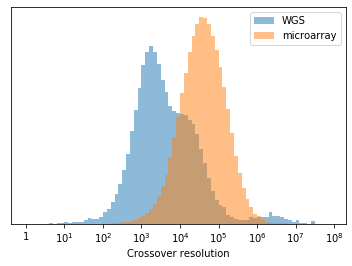

In [3]:
lengths_wgs_mat = np.load(get_filename('crossover_lengths_mat', (0.5, 0.5)))
lengths_wgs_pat = np.load(get_filename('crossover_lengths_pat', (0.5, 0.5)))

lengths_chip_mat = np.load(get_filename('crossover_lengths_mat', (0.5, 0.5), recomb_dir='../recomb_spark'))
lengths_chip_pat = np.load(get_filename('crossover_lengths_pat', (0.5, 0.5), recomb_dir='../recomb_spark'))

print(np.median(np.hstack((lengths_wgs_mat, lengths_wgs_pat))))
print(np.median(np.hstack((lengths_chip_mat, lengths_chip_pat))))

plt.hist(np.log10(np.hstack((lengths_wgs_mat, lengths_wgs_pat))), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label='WGS')
plt.hist(np.log10(np.hstack((lengths_chip_mat, lengths_chip_pat))), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), density=True, label='microarray')
plt.xlabel('Crossover resolution')
plt.xticks(np.arange(0, 9), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9)])
plt.yticks([])
plt.legend()
plt.show()

In [4]:
lengths_mat = np.load('%s/recombination_rates/lengths_mat.npy' % (recomb_dir))
lengths_pat = np.load('%s/recombination_rates/lengths_pat.npy' % (recomb_dir))


chroms_mat, start_pos_mat, end_pos_mat = [], [], []
chroms_pat, start_pos_pat, end_pos_pat = [], [], []
with open('%s/recombination_rates/intervals_mat.txt' % recomb_dir, 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chroms_mat.append(pieces[0])
        start_pos_mat.append(int(pieces[1]))
        end_pos_mat.append(int(pieces[2]))
            
with open('%s/recombination_rates/intervals_pat.txt' % recomb_dir, 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chroms_pat.append(pieces[0])
        start_pos_pat.append(int(pieces[1]))
        end_pos_pat.append(int(pieces[2]))
            
start_pos_mat = np.array(start_pos_mat)
start_pos_pat = np.array(start_pos_pat)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


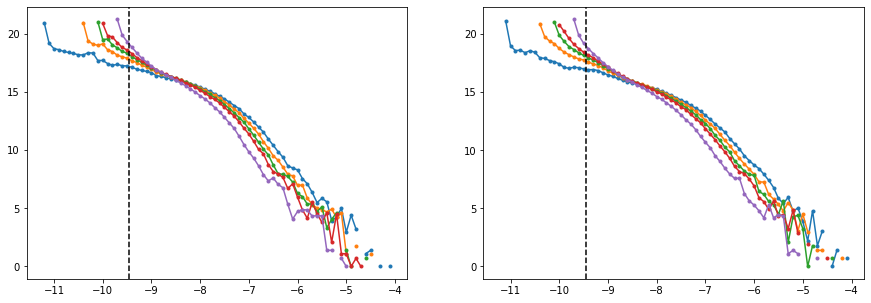

In [5]:
bins=np.arange(-21, 0.1, 0.1)

plt.figure(figsize=(15, 5))


ax = plt.subplot(1, 2, 1)
for lamb in lambs:
    try:
        ps_mat = np.load(get_filename('ps_mat', lamb, 0))
        if np.abs(np.sum(ps_mat.dot(lengths_mat))-1)<0.05:
            d = np.digitize(np.log10(ps_mat), bins)
            ps_hist = [np.sum(lengths_mat[d==i]) for i in range(len(bins))]
            plt.plot(bins, np.log(ps_hist), marker='.')
    except FileNotFoundError:
        pass
    

plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')

plt.subplot(1, 2, 2, sharex=ax)
for lamb in lambs:
    try:
        ps_pat = np.load(get_filename('ps_pat', lamb, 0))
        if np.abs(np.sum(ps_pat.dot(lengths_pat))-1)<0.05:
            d = np.digitize(np.log10(ps_pat), bins)
            ps_hist = [np.sum(lengths_pat[d==i]) for i in range(len(bins))]
            plt.plot(bins, np.log(ps_hist), marker='.')
    except FileNotFoundError:
        pass

plt.axvline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


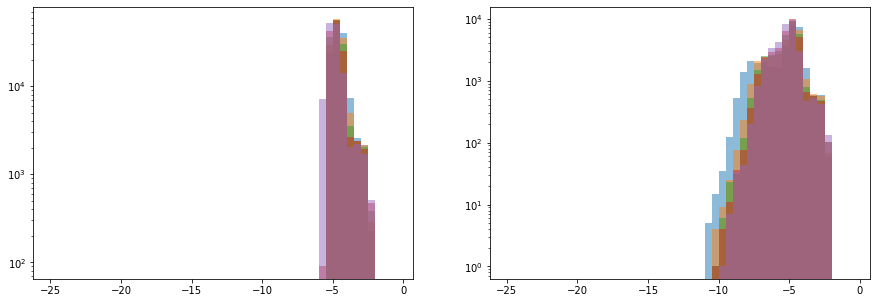

In [6]:
bins=np.arange(-25, 0, 0.5)
plt.figure(figsize=(15, 5))
for i in range(len(lambs)):
    plt.subplot(1, 2, 1)
    try:
        ps_mat = np.log10(np.load(get_filename('crossover_ps_mat_train', lambs[i], 0)))
        plt.hist(ps_mat, bins=bins, alpha=0.5, log=True)  
    except FileNotFoundError:
        pass
    
    plt.subplot(1, 2, 2)
    try:
        ps_mat = np.log10(np.load(get_filename('crossover_ps_mat_test', lambs[i], 0)))
        plt.hist(ps_mat, bins=bins, alpha=0.5, log=True)  
    except FileNotFoundError:
        pass

plt.show()

In [7]:
co_mat_train, co_mat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
co_pat_train, co_pat_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
co_train, co_test = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)

co_mat_train_baseline, co_mat_test_baseline = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
co_pat_train_baseline, co_pat_test_baseline = np.full((len(lambs), kfolds), np.nan), np.full((len(lambs), kfolds), np.nan)
   
for i, lamb in enumerate(lambs):
    for k in range(kfolds):
        if exists(get_filename('ps_pat', lamb, k)):
            ps = np.load(get_filename('ps_mat', lamb, k))
            if np.abs(np.sum(ps.dot(lengths_mat))-1)<0.05:
                ps_train = np.load(get_filename('crossover_ps_mat_train', lamb, k))
                ps_test = np.load(get_filename('crossover_ps_mat_test', lamb, k))

                co_mat_train[i, k] = np.sum(np.clip(np.log10(ps_train), -20, None))/len(ps_train)
                co_mat_test[i, k] = np.sum(np.clip(np.log10(ps_test), -20, None))/len(ps_test)

                lengths_train = np.load(get_filename('crossover_lengths_mat_train', lamb, k))
                lengths_test = np.load(get_filename('crossover_lengths_mat_test', lamb, k))
                co_mat_train_baseline[i, k] = np.sum(np.log10(lengths_train/np.sum(lengths_mat)))/len(ps_train)
                co_mat_test_baseline[i, k] = np.sum(np.log10(lengths_test/np.sum(lengths_mat)))/len(ps_test)
            else:
                print('ps dont sum to 1', recomb_dir, lamb, k, np.sum(ps.dot(lengths_mat)))
                    
            ps = np.load(get_filename('ps_pat', lamb, k))
            if np.abs(np.sum(ps.dot(lengths_pat))-1)<0.05:
                ps_train = np.load(get_filename('crossover_ps_pat_train', lamb, k))
                ps_test = np.load(get_filename('crossover_ps_pat_test', lamb, k))

                co_pat_train[i, k] = np.sum(np.clip(np.log10(ps_train), -20, None))/len(ps_train)
                co_pat_test[i, k] = np.sum(np.clip(np.log10(ps_test), -20, None))/len(ps_test)

                lengths_train = np.load(get_filename('crossover_lengths_pat_train', lamb, k))
                lengths_test = np.load(get_filename('crossover_lengths_pat_test', lamb, k))
                co_pat_train_baseline[i, k] = np.sum(np.log10(lengths_train/np.sum(lengths_pat)))/len(ps_train)
                co_pat_test_baseline[i, k] = np.sum(np.log10(lengths_test/np.sum(lengths_pat)))/len(ps_test)
            else:
                print('ps dont sum to 1', recomb_dir, lamb, k, np.sum(ps.dot(lengths_pat)))
                
            ps_train = np.hstack((np.load(get_filename('crossover_ps_mat_train', lamb, k)),
                                  np.load(get_filename('crossover_ps_pat_train', lamb, k))))
            ps_test = np.hstack((np.load(get_filename('crossover_ps_mat_test', lamb, k)),
                                  np.load(get_filename('crossover_ps_pat_test', lamb, k))))

            co_train[i, k] = np.sum(np.clip(np.log10(ps_train), -20, None))/len(ps_train)
            co_test[i, k] = np.sum(np.clip(np.log10(ps_test), -20, None))/len(ps_test)
                
            



In [8]:
print(co_test)


[[-5.35108947 -5.37211252 -5.364104   -5.37044454 -5.34971702]
 [-5.18755016 -5.19453396 -5.21128955 -5.2158481  -5.20054277]
 [-5.18123136 -5.1851664  -5.17125755 -5.16577067 -5.17871544]
 [-5.18009186 -5.16329067 -5.17744168 -5.18441938 -5.18979257]
 [-5.23553026 -5.2231214  -5.22388601 -5.23463228 -5.22133331]]


In [9]:
ps_test_mat = np.load(get_filename('crossover_ps_mat_test', (0.5, 0.5), 0, recomb_dir='../recomb_ssc.hg38.spark'))
ps_test_pat = np.load(get_filename('crossover_ps_pat_test', (0.5, 0.5), 0, recomb_dir='../recomb_ssc.hg38.spark'))
    
print(np.sum(np.clip(np.log10(ps_test_mat), -20, None))/len(ps_test_mat))
print(np.sum(np.clip(np.log10(ps_test_pat), -20, None))/len(ps_test_pat))

-5.265801126025016
-5.198482171109399


mat [-4.5501946  -4.61539455 -4.67738077 -4.73023478 -4.87771794]
pat [-4.40188739 -4.47390624 -4.54248393 -4.60050651 -4.76172768]
both [-4.49191688 -4.55979587 -4.62437276 -4.67925763 -4.83213917]
mat [-5.3919761  -5.23610016 -5.20957755 -5.21031427 -5.25472807]
pat [-5.31439849 -5.14921138 -5.12519503 -5.13063698 -5.18593842]
both [-5.36149351 -5.20195291 -5.17642828 -5.17900723 -5.22770065]


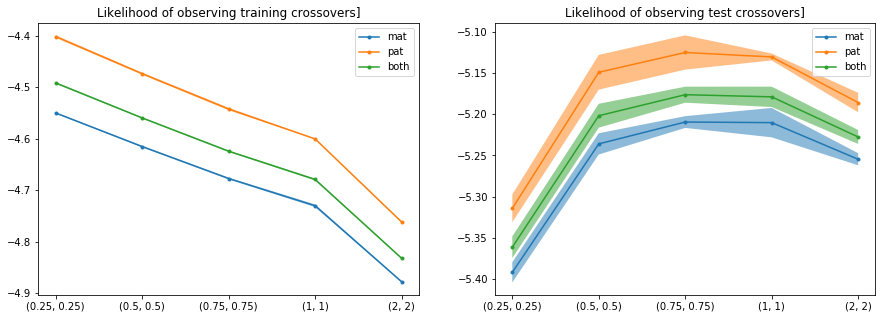

In [32]:
def plot_with_confidence(data, label):
    #print(np.nanmean(data, axis=1))
    plt.plot(range(len(lambs)), np.nanmean(data, axis=1), label=label, marker='.')
    lower, upper = stats.t.interval(0.95, data.shape[1]-1, loc=np.nanmean(data, axis=1), scale=stats.sem(data, axis=1, nan_policy='omit')) # from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    plt.fill_between(range(len(lambs)), lower, upper, alpha=0.5)
    print(label, np.nanmean(data, axis=1))


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
#plot_with_confidence(co_mat_train_baseline, 'baseline')
plot_with_confidence(co_mat_train, 'mat')
plot_with_confidence(co_pat_train, 'pat')
plot_with_confidence(co_train, 'both')

plt.title('Likelihood of observing training crossovers]')
plt.xticks(range(len(lambs)), lambs)
plt.legend()

plt.subplot(1, 2, 2)
#plot_with_confidence(co_mat_test_baseline, 'baseline')
plot_with_confidence(co_mat_test, 'mat')
plot_with_confidence(co_pat_test, 'pat')
plot_with_confidence(co_test, 'both')

plt.title('Likelihood of observing test crossovers]')
plt.xticks(range(len(lambs)), lambs)
plt.legend()


plt.show()



# Look at best performer

In [33]:
lamb = (0.75, 0.75)
ps_mat = np.load(get_filename('ps_mat', lamb, 0))
ps_pat = np.load(get_filename('ps_pat', lamb, 0))

ps_train_mat = np.load(get_filename('crossover_ps_mat_train', lamb, 0))
ps_test_mat = np.load(get_filename('crossover_ps_mat_test', lamb, 0))
ps_train_pat = np.load(get_filename('crossover_ps_pat_train', lamb, 0))
ps_test_pat = np.load(get_filename('crossover_ps_pat_test', lamb, 0))

lengths_test_mat = np.load(get_filename('crossover_lengths_mat_test', lamb, 0))
lengths_test_pat = np.load(get_filename('crossover_lengths_pat_test', lamb, 0))


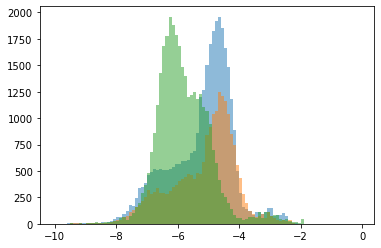

In [34]:
plt.hist(np.log10(ps_test_mat), bins=np.arange(-10, 0, 0.1), alpha=0.5)
plt.hist(np.log10(ps_test_pat), bins=np.arange(-10, 0, 0.1), alpha=0.5)
plt.hist(np.log10(lengths_test_mat)-np.log10(np.sum(lengths_mat)), bins=np.arange(-10, 0, 0.1), alpha=0.5)
plt.show()

0.7229198415117343
0.3343188052423042
0.7341819896275342
0.38524280999528526


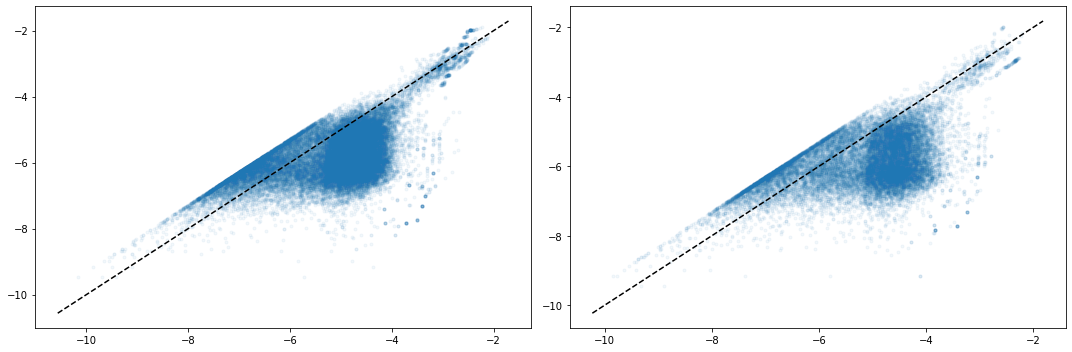

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.log10(ps_test_mat), np.log10(lengths_test_mat)-np.log10(np.sum(lengths_mat)), marker='.', alpha=0.05)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

print(np.sum(np.log10(ps_test_mat)>(np.log10(lengths_test_mat)-np.log10(np.sum(lengths_mat))))/len(ps_test_mat))
print(np.sum(np.log10(ps_test_mat)-1>(np.log10(lengths_test_mat)-np.log10(np.sum(lengths_mat))))/len(ps_test_mat))

plt.subplot(1, 2, 2)
plt.scatter(np.log10(ps_test_pat), np.log10(lengths_test_pat)-np.log10(np.sum(lengths_pat)), marker='.', alpha=0.05)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

print(np.sum(np.log10(ps_test_pat)>(np.log10(lengths_test_pat)-np.log10(np.sum(lengths_pat))))/len(ps_test_pat))
print(np.sum(np.log10(ps_test_pat)-1>(np.log10(lengths_test_pat)-np.log10(np.sum(lengths_pat))))/len(ps_test_pat))

plt.tight_layout()
plt.show()

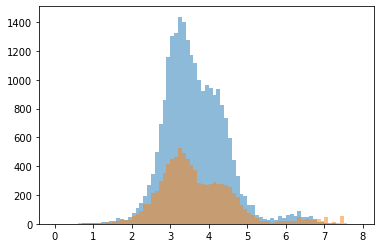

In [36]:
indices = np.log10(ps_test_mat)>(np.log10(lengths_test_mat)-np.log10(np.sum(lengths_mat)))
plt.hist(np.log10(lengths_test_mat[indices]), alpha=0.5, bins=np.arange(0, 8, 0.1))
plt.hist(np.log10(lengths_test_mat[~indices]), alpha=0.5, bins=np.arange(0, 8, 0.1))
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


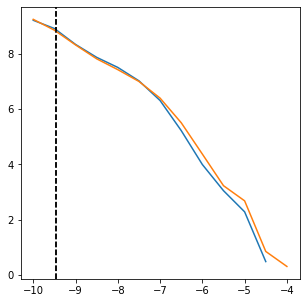

In [37]:
bins=np.arange(-21, 0.01, 0.5)
plt.figure(figsize=(5, 5))
    
d = np.digitize(np.log10(ps_mat), bins)
ps_hist = [np.sum(lengths_mat[d==i]) for i in range(len(bins))]
plt.plot(bins, np.log10(ps_hist))
plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
 
d = np.digitize(np.log10(ps_pat), bins)
ps_hist = [np.sum(lengths_pat[d==i]) for i in range(len(bins))]
plt.plot(bins, np.log10(ps_hist))
plt.axvline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')

plt.show()

In [38]:
is_hotspot_mat = np.log10(ps_mat) > np.log10(1/np.sum(lengths_mat))
is_hotspot_pat = np.log10(ps_pat) > np.log10(1/np.sum(lengths_pat))

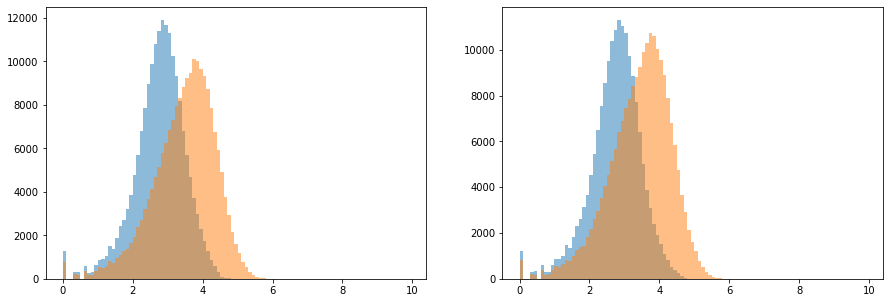

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(lengths_mat[is_hotspot_mat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.hist(np.log10(lengths_mat[~is_hotspot_mat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.subplot(1, 2, 2)
plt.hist(np.log10(lengths_pat[is_hotspot_pat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.hist(np.log10(lengths_pat[~is_hotspot_pat]), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.show()

In [40]:
print(np.median(lengths_mat[is_hotspot_mat]), np.median(lengths_pat[is_hotspot_pat]))

657.0 636.0


In [41]:
indices = np.where(is_hotspot_mat[1:] != is_hotspot_mat[:-1])[0].tolist() + [len(ps_mat)-1]
#indices = np.where(np.abs(np.log10(ps_mat[1:])-np.log10(ps_mat[:-1]) > 2))[0].tolist() + [len(ps_mat)-1]
interval_lengths_mat, interval_ps_mat = [], []
interval_mapping_mat = []
    
last_index = 0
for i in indices:
    #print(ps_mat[last_index], ps_mat[i])
    #assert np.isclose(ps_mat[last_index], ps_mat[i])
    index = len(interval_lengths_mat)
    l = np.sum(lengths_mat[last_index:(i+1)])
    interval_lengths_mat.append(l)
    interval_ps_mat.append(ps_mat[last_index:(i+1)].dot(lengths_mat[last_index:(i+1)])/l)
    interval_mapping_mat.extend([index]*(i+1-last_index))
    last_index = i+1

    
interval_lengths_mat = np.array(interval_lengths_mat)
interval_ps_mat = np.array(interval_ps_mat)
interval_mapping_mat = np.array(interval_mapping_mat)
print(len(interval_mapping_mat), len(lengths_mat))
assert len(interval_mapping_mat) == len(lengths_mat)

indices = np.where(is_hotspot_pat[1:] != is_hotspot_pat[:-1])[0].tolist() + [len(ps_pat)-1]
#indices = np.where(np.abs(np.log10(ps_pat[1:])-np.log10(ps_pat[:-1]) > 2))[0].tolist() + [len(ps_pat)-1]
interval_lengths_pat, interval_ps_pat = [], []
interval_mapping_pat = []
    
last_index = 0
for i in indices:
    #print(ps_mat[last_index], ps_mat[i])
    #assert np.isclose(ps_mat[last_index], ps_mat[i])
    index = len(interval_lengths_pat)
    l = np.sum(lengths_pat[last_index:(i+1)])
    interval_lengths_pat.append(l)
    interval_ps_pat.append(ps_pat[last_index:(i+1)].dot(lengths_pat[last_index:(i+1)])/l)
    interval_mapping_pat.extend([index]*(i+1-last_index))
    last_index = i+1
    
interval_lengths_pat = np.array(interval_lengths_pat)
interval_ps_pat = np.array(interval_ps_pat)
interval_mapping_pat = np.array(interval_mapping_pat)
assert len(interval_mapping_pat) == len(lengths_pat)

print(len(interval_lengths_mat), len(interval_lengths_pat))

380099 380099
133347 126613


In [42]:
interval_is_hot_mat = np.log10(interval_ps_mat)>np.log10(1/np.sum(lengths_mat))
interval_is_hot_pat = np.log10(interval_ps_pat)>np.log10(1/np.sum(lengths_pat))

print(np.sum(interval_is_hot_mat), np.sum(interval_is_hot_pat))

66673 63306


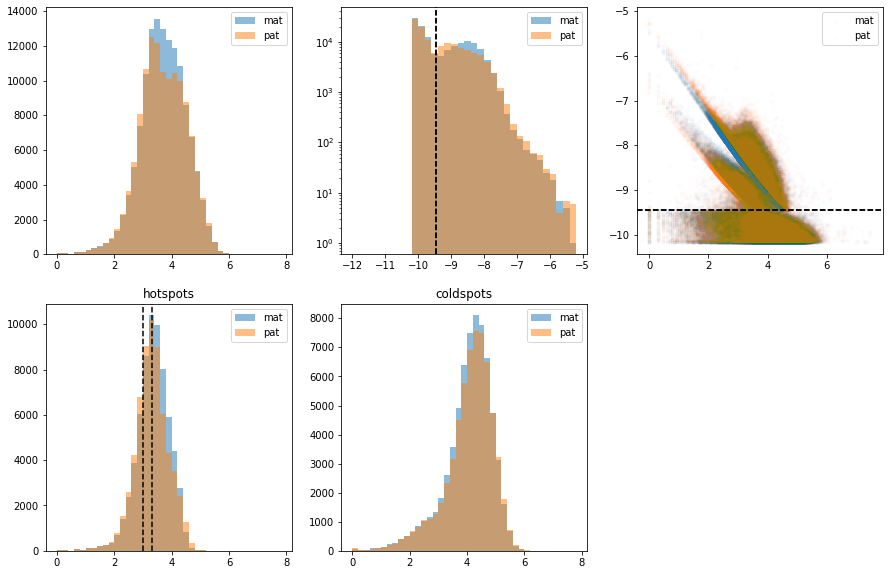

In [43]:
# look at intervals

bins=np.arange(-25, 0, 0.5)
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(np.log10(interval_lengths_mat), bins=np.arange(0, 8, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(interval_lengths_pat), bins=np.arange(0, 8, 0.2), alpha=0.5, label='pat')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(np.log10(interval_ps_mat), log=True, bins=np.arange(-12, -5, 0.2), alpha=0.5, label='mat')
plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
plt.hist(np.log10(interval_ps_pat), log=True, bins=np.arange(-12, -5, 0.2), alpha=0.5, label='pat')
plt.axvline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
plt.legend()

plt.subplot(2, 3, 3)
plt.scatter(np.log10(interval_lengths_mat), np.log10(interval_ps_mat), alpha=0.01, marker='.', label='mat')
plt.axhline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
plt.scatter(np.log10(interval_lengths_pat), np.log10(interval_ps_pat), alpha=0.01, marker='.', label='pat')
plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
plt.legend()

plt.subplot(2, 3, 4)
#plt.title('hotspots')
plt.title('hotspots')
plt.hist(np.log10(interval_lengths_mat[interval_is_hot_mat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='mat')

plt.hist(np.log10(interval_lengths_pat[interval_is_hot_pat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='pat')
plt.axvline(np.log10(1000), color='black', linestyle='--')
plt.axvline(np.log10(2000), color='black', linestyle='--')

plt.legend()

plt.subplot(2, 3, 5)
plt.title('coldspots')
plt.hist(np.log10(interval_lengths_mat[~interval_is_hot_mat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='mat')
plt.hist(np.log10(interval_lengths_pat[~interval_is_hot_pat]), 
         bins=np.arange(0, 8, 0.2), alpha=0.5, label='pat')
#plt.axvline(np.log10(1000), color='black', linestyle='--')
#plt.axvline(np.log10(2000), color='black', linestyle='--')
plt.legend()


plt.show()

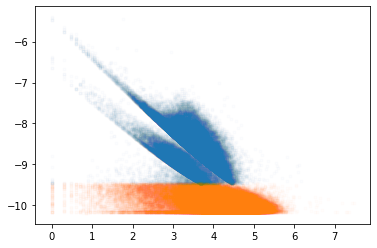

In [44]:
plt.scatter(np.log10(interval_lengths_mat[interval_is_hot_mat]), np.log10(interval_ps_mat[interval_is_hot_mat]),
           marker='.', alpha=0.01)
plt.scatter(np.log10(interval_lengths_mat[~interval_is_hot_mat]), np.log10(interval_ps_mat[~interval_is_hot_mat]),
           marker='.', alpha=0.01)
plt.show()

In [45]:
print(np.median(interval_lengths_mat[interval_is_hot_mat]),
      np.median(interval_lengths_mat[~interval_is_hot_mat]))
print(np.median(interval_lengths_pat[interval_is_hot_pat]),
      np.median(interval_lengths_pat[~interval_is_hot_pat]))

2383.0 15491.0
2026.0 16480.0


380099 380099
-9.0 1400.0 1239.0
380099 380099
-8.5 865.0 901.0


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


380099 380099
-8.0 435.0 514.0
380099 380099
-7.5 181.0 228.0


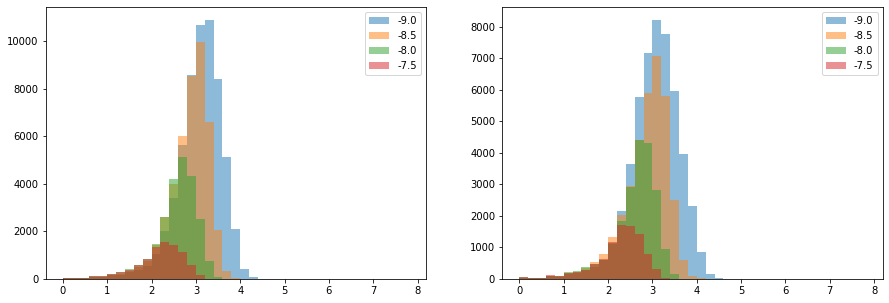

In [46]:
def get_hotspot_lengths(cutoff):
    is_hotspot_mat = np.log10(ps_mat) > cutoff
    is_hotspot_pat = np.log10(ps_pat) > cutoff

    indices = np.where(is_hotspot_mat[1:] != is_hotspot_mat[:-1])[0].tolist() + [len(ps_mat)-1]
    interval_lengths_mat, interval_ps_mat = [], []

    last_index = 0
    for i in indices:
        index = len(interval_lengths_mat)
        l = np.sum(lengths_mat[last_index:(i+1)])
        interval_lengths_mat.append(l)
        interval_ps_mat.append(ps_mat[last_index:(i+1)].dot(lengths_mat[last_index:(i+1)])/l)
        last_index = i+1

    interval_lengths_mat = np.array(interval_lengths_mat)
    interval_ps_mat = np.array(interval_ps_mat)
    print(len(interval_mapping_mat), len(lengths_mat))

    indices = np.where(is_hotspot_pat[1:] != is_hotspot_pat[:-1])[0].tolist() + [len(ps_pat)-1]
    interval_lengths_pat, interval_ps_pat = [], []

    last_index = 0
    for i in indices:
        index = len(interval_lengths_pat)
        l = np.sum(lengths_pat[last_index:(i+1)])
        interval_lengths_pat.append(l)
        interval_ps_pat.append(ps_pat[last_index:(i+1)].dot(lengths_pat[last_index:(i+1)])/l)
        last_index = i+1

    interval_lengths_pat = np.array(interval_lengths_pat)
    interval_ps_pat = np.array(interval_ps_pat)
    
    interval_is_hot_mat = np.log10(interval_ps_mat)>cutoff
    interval_is_hot_pat = np.log10(interval_ps_pat)>cutoff
    return interval_lengths_mat[interval_is_hot_mat], interval_lengths_pat[interval_is_hot_pat]

plt.figure(figsize=(15, 5))

for i in np.arange(-9, -7, 0.5):
    m, p = get_hotspot_lengths(i)
    print(i, np.median(m), np.median(p))
    plt.subplot(1, 2, 1)
    plt.hist(np.log10(m), bins=np.arange(0, 8, 0.2), alpha=0.5, label=str(i))
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(np.log10(p), bins=np.arange(0, 8, 0.2), alpha=0.5, label=str(i))
    plt.legend()
plt.show()





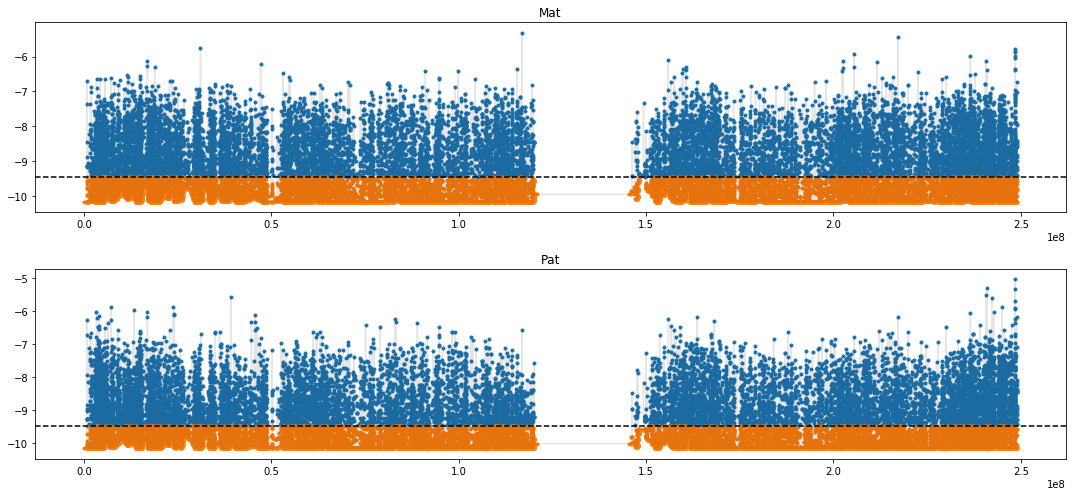

In [47]:
chrom = '1'
plt.figure(figsize=(15, 7))

ax = plt.subplot(2, 1, 1)
plt.title('Mat')
indices = [c==chrom for c in chroms_mat]
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])), 2)[:-1], alpha=0.1, color='black')
plt.scatter(start_pos_mat[indices & is_hotspot_mat],
                    np.log10(ps_mat[indices & is_hotspot_mat]), marker='.')
plt.scatter(start_pos_mat[indices & ~is_hotspot_mat],
                    np.log10(ps_mat[indices & ~is_hotspot_mat]), marker='.')

#for i in range(3):
#    plt.scatter(start_pos_mat[indices & np.isin(interval_mapping_mat, np.where(clustering_mat.labels_==i)[0])],
#                np.log10(ps_mat[indices & np.isin(interval_mapping_mat, np.where(clustering_mat.labels_==i)[0])]), marker='.')
plt.axhline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
#plt.xlim([10000000, 11000000])
        
plt.subplot(2, 1, 2, sharex=ax)
plt.title('Pat')
indices = [c==chrom for c in chroms_pat]
q = plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
                 np.repeat((np.log10(ps_pat[indices])), 2)[:-1], alpha=0.1, color='black')
plt.scatter(start_pos_pat[indices & is_hotspot_pat],
                    np.log10(ps_pat[indices & is_hotspot_pat]), marker='.')
plt.scatter(start_pos_pat[indices & ~is_hotspot_pat],
                    np.log10(ps_pat[indices & ~is_hotspot_pat]), marker='.')
#for i in range(3):
#    plt.scatter(start_pos_pat[indices & np.isin(interval_mapping_pat, np.where(clustering_pat.labels_==i)[0])],
#                np.log10(ps_pat[indices & np.isin(interval_mapping_pat, np.where(clustering_pat.labels_==i)[0])]), marker='.')

plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([0, 10000000])
#plt.ylim([-12, -8])

plt.tight_layout()
plt.show()


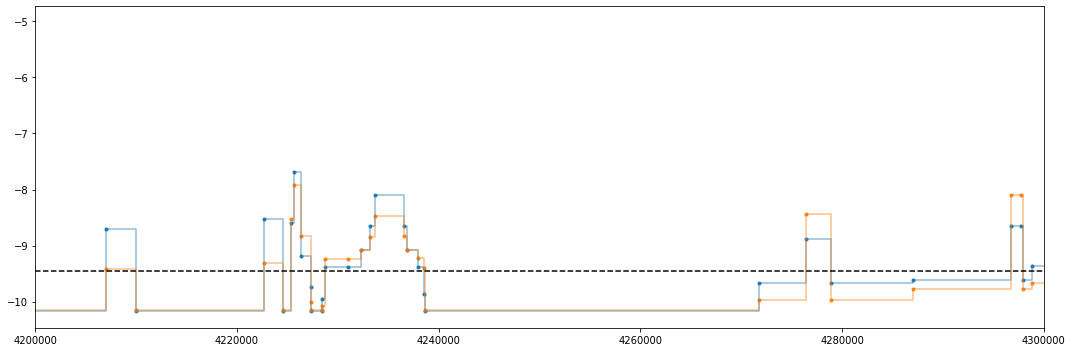

In [48]:
chrom = '1'
plt.figure(figsize=(15, 5))

indices = np.array([c==chrom for c in chroms_mat])
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])), 2)[:-1], alpha=0.5)

#indices = indices & (np.abs(np.log10(ps_mat)-np.log10(ps_pat))>1)
plt.scatter(start_pos_mat[indices], np.log10(ps_mat[indices]), marker='.')

indices = [c==chrom for c in chroms_pat]
q = plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
                 np.repeat((np.log10(ps_pat[indices])), 2)[:-1], alpha=0.5)

#indices = indices & (np.abs(np.log10(ps_mat)-np.log10(ps_pat))>1)
plt.scatter(start_pos_pat[indices], np.log10(ps_pat[indices]), marker='.')

plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
plt.xlim([4200000, 4300000])
#plt.ylim([-12, -8])

plt.tight_layout()
plt.show()


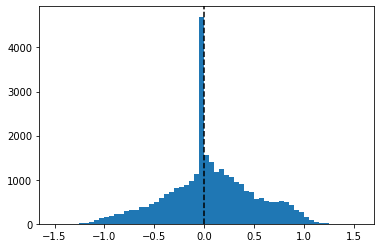

In [49]:
plt.hist(np.log10(ps_mat[indices])-np.log10(ps_pat[indices]), bins=np.arange(-1.5, 1.6, 0.05))
plt.axvline(0, color='black', linestyle='--')
plt.show()

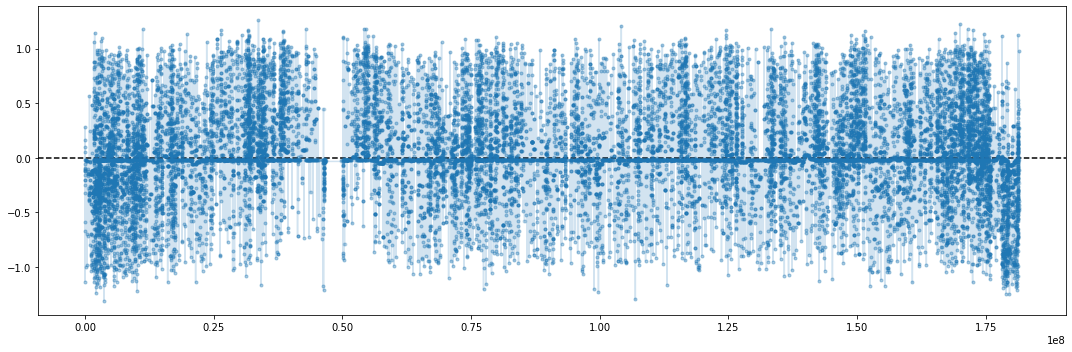

In [50]:
chrom = '5'
plt.figure(figsize=(15, 5))

plt.axhline(0, color='black', linestyle='--')
indices = np.array([c==chrom for c in chroms_mat])
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])-np.log10(ps_pat[indices])), 2)[:-1], 
             alpha=0.2, marker='.')


#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([0, 5000000])
#plt.ylim([-12, -8])

plt.tight_layout()
plt.show()


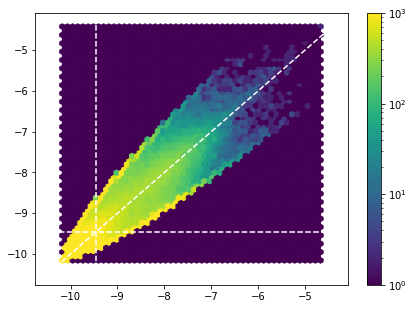

In [51]:
plt.figure(figsize=(7, 5))
plt.hexbin(np.log10(ps_mat), np.log10(ps_pat), gridsize=50, bins='log', vmax=10**3)
plt.colorbar()
plt.axvline(np.log10(1/np.sum(lengths_mat)), color='white', linestyle='--')
plt.axhline(np.log10(1/np.sum(lengths_pat)), color='white', linestyle='--')
plt.plot(plt.xlim(), plt.xlim(), color='white', linestyle='--')
plt.show()

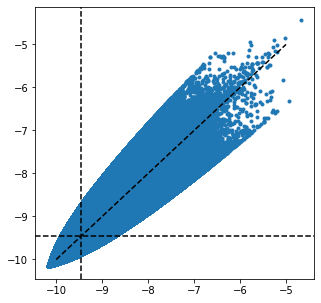

In [52]:
plt.figure(figsize=(5, 5))
plt.scatter(np.log10(ps_mat), np.log10(ps_pat), marker='.', alpha=1)
plt.plot([-10, -5], [-10, -5], color='black', linestyle='--')
plt.axvline(np.log10(1/np.sum(lengths_mat)), color='black', linestyle='--')
plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')

plt.show()

# look at stacked crossovers

In [351]:
chroms = [str(x) for x in range(1, 23)]

# From GRCh38.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh38.p13
chrom_lengths = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
	'X': 156040895,
	'Y': 57227415
}



def check_crossovers(crossovers):
	for co in crossovers:
		if co['start_pos'] == co['end_pos']:
			print(co)
		assert co['start_pos'] != co['end_pos']

	# remove quads/crossovers involving the same child
	quads = set()
	children = set()
	ok_crossovers = []
	for co in crossovers:
		if tuple(co['child']) in quads:
			ok_crossovers.append(co)
		elif co['child'][0] in children or co['child'][1] in children:
			pass
		else:
			quads.add(tuple(co['child']))
			children.add(co['child'][0])
			children.add(co['child'][1])
			ok_crossovers.append(co)

	print('children with phase information', 2*len(quads))
	print('removed crossovers from siblings in multiple sibpairs', len(crossovers)-len(ok_crossovers))
	return ok_crossovers, sorted(quads)

# pull crossover information
with open('%s/crossovers.json' % recomb_dir, 'r') as f:
	crossovers, quads = check_crossovers(json.load(f))


# pull intervals
chrom_to_positions_mat, chrom_to_positions_pat = defaultdict(set), defaultdict(set)
num_crossovers_mat, num_crossovers_pat = 0, 0

for co in crossovers:
	if co['is_mat']:
		chrom_to_positions_mat[co['chrom']].add(co['start_pos'])
		chrom_to_positions_mat[co['chrom']].add(co['end_pos'])
		chrom_to_positions_pat[co['chrom']].add(co['start_pos'])
		chrom_to_positions_pat[co['chrom']].add(co['end_pos'])

		num_crossovers_mat += 1
		
	if co['is_pat']:
		chrom_to_positions_mat[co['chrom']].add(co['start_pos'])
		chrom_to_positions_mat[co['chrom']].add(co['end_pos'])
		chrom_to_positions_pat[co['chrom']].add(co['start_pos'])
		chrom_to_positions_pat[co['chrom']].add(co['end_pos'])
		num_crossovers_pat += 1

print('num_crossovers_mat', num_crossovers_mat, 'num_crossovers_pat', num_crossovers_pat)

for chrom in chroms:
	positions_mat = chrom_to_positions_mat[chrom]
	positions_mat.add(1)
	positions_mat.add(chrom_lengths[chrom])
	positions_pat = chrom_to_positions_pat[chrom]
	positions_pat.add(1)
	positions_pat.add(chrom_lengths[chrom])

	positions_mat = np.array(sorted(positions_mat))
	positions_pat = np.array(sorted(positions_pat))

	chrom_to_positions_mat[chrom] = positions_mat
	chrom_to_positions_pat[chrom] = positions_pat

	print('chr', chrom, 'intervals_mat', len(chrom_to_positions_mat[chrom]), 'intervals_pat', chrom_to_positions_pat[chrom])
	

# create feature matrix for each chrom
cross_mat, cross_pat = [], []

chrom_index_offset_mat, chrom_index_offset_pat = 0, 0

for i, chrom in enumerate(chroms):
	positions = chrom_to_positions_mat[chrom]
	pos_to_index = dict([(x, i) for i, x in enumerate(positions)])
	cos = [co for co in crossovers if co['chrom']==chrom and co['is_mat']]
	data = np.zeros((len(positions)-1,), dtype=int)
	for row_i, co in enumerate(cos):
		start_index, end_index = pos_to_index[co['start_pos']], pos_to_index[co['end_pos']]
		data[start_index:end_index] += 1
	cross_mat.append(data)

	positions = chrom_to_positions_pat[chrom]
	pos_to_index = dict([(x, i) for i, x in enumerate(positions)])
	cos = [co for co in crossovers if co['chrom']==chrom and co['is_pat']]
	data = np.zeros((len(positions)-1,), dtype=int)
	for row_i, co in enumerate(cos):
		start_index, end_index = pos_to_index[co['start_pos']], pos_to_index[co['end_pos']]
		data[start_index:end_index] += 1
	cross_pat.append(data)

cross_mat = np.hstack(cross_mat)
cross_pat = np.hstack(cross_pat)


children with phase information 3810
removed crossovers from siblings in multiple sibpairs 0
num_crossovers_mat 164357 num_crossovers_pat 106393
chr 1 intervals_mat 30810 intervals_pat [        1    825898    828014 ... 248944850 248944900 248956422]
chr 2 intervals_mat 29038 intervals_pat [        1     23368     38938 ... 242182922 242182973 242193529]
chr 3 intervals_mat 24433 intervals_pat [        1     36356     39503 ... 198117603 198180840 198295559]
chr 4 intervals_mat 23308 intervals_pat [        1     15286     15295 ... 190020832 190021589 190214555]
chr 5 intervals_mat 22508 intervals_pat [        1     12126     12130 ... 181474128 181474336 181538259]
chr 6 intervals_mat 21923 intervals_pat [        1    110222    110300 ... 170741611 170741909 170805979]
chr 7 intervals_mat 20647 intervals_pat [        1     21073     22948 ... 159335026 159335207 159345973]
chr 8 intervals_mat 18720 intervals_pat [        1     71219     75670 ... 145046441 145046469 145138636]
chr 9 i

In [352]:
print(cross_mat.shape, len(lengths_mat))

(380099,) 380099


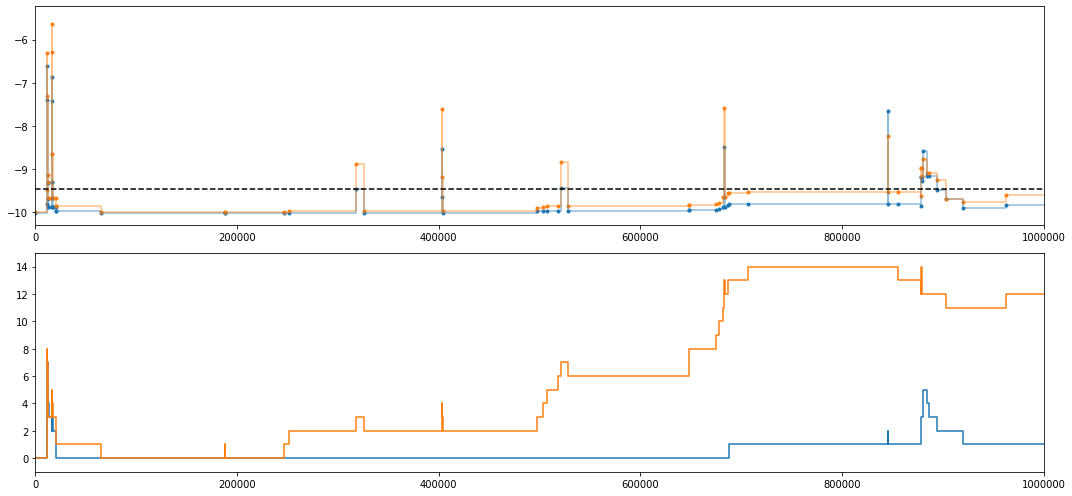

In [353]:
chrom = '5'
plt.figure(figsize=(15, 7))

ax = plt.subplot(2, 1, 1)

indices = np.array([c==chrom for c in chroms_mat])
p = plt.plot(np.repeat(start_pos_mat[indices], 2)[1:], 
                     np.repeat((np.log10(ps_mat[indices])), 2)[:-1], alpha=0.5)

#indices = indices & (np.abs(np.log10(ps_mat)-np.log10(ps_pat))>1)
plt.scatter(start_pos_mat[indices], np.log10(ps_mat[indices]), marker='.')

indices = [c==chrom for c in chroms_pat]
q = plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
                 np.repeat((np.log10(ps_pat[indices])), 2)[:-1], alpha=0.5)

#indices = indices & (np.abs(np.log10(ps_mat)-np.log10(ps_pat))>1)
plt.scatter(start_pos_pat[indices], np.log10(ps_pat[indices]), marker='.')

plt.axhline(np.log10(1/np.sum(lengths_pat)), color='black', linestyle='--')
#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.ylim([-12, -8])

plt.subplot(2, 1, 2, sharex=ax)
indices = np.array([c==chrom for c in chroms_mat])
plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
         np.repeat(cross_mat[indices], 2)[:-1])

indices = np.array([c==chrom for c in chroms_pat])
plt.plot(np.repeat(start_pos_pat[indices], 2)[1:], 
         np.repeat(cross_pat[indices], 2)[:-1])

plt.ylim([-1, 15])
plt.xlim([0, 1000000])

plt.tight_layout()
plt.show()


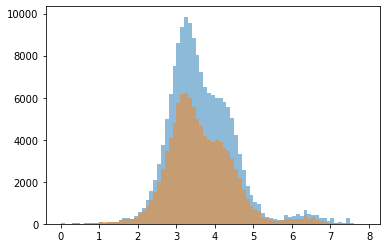

In [354]:
plt.hist(np.log10(lengths_wgs_mat), bins=np.arange(0, 8, 0.1), alpha=0.5)
plt.hist(np.log10(lengths_wgs_pat), bins=np.arange(0, 8, 0.1), alpha=0.5)
plt.show()

380099 380099
21 2652.0 2273.5
380099 380099
21 781.0 836.0


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


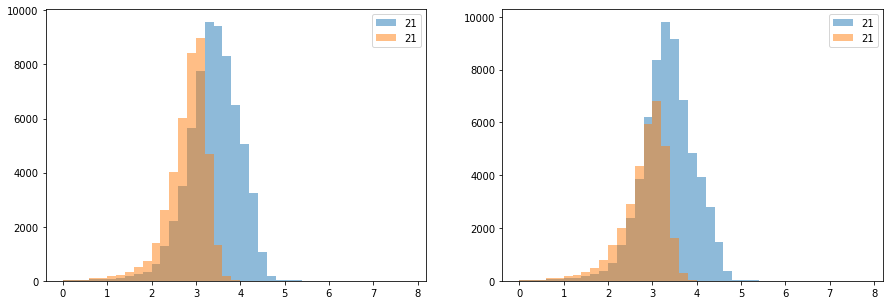

In [355]:

plt.figure(figsize=(15, 5))

m, p = get_hotspot_lengths(-np.log10(np.sum(lengths_mat)))
print(i, np.median(m), np.median(p))

plt.subplot(1, 2, 1)
plt.hist(np.log10(m), bins=np.arange(0, 8, 0.2), alpha=0.5, label=str(i))
plt.legend()
    
plt.subplot(1, 2, 2)
plt.hist(np.log10(p), bins=np.arange(0, 8, 0.2), alpha=0.5, label=str(i))
plt.legend()

m, p = get_hotspot_lengths(-np.log10(np.sum(lengths_mat))+1)
print(i, np.median(m), np.median(p))

plt.subplot(1, 2, 1)
plt.hist(np.log10(m), bins=np.arange(0, 8, 0.2), alpha=0.5, label=str(i))
plt.legend()
    
plt.subplot(1, 2, 2)
plt.hist(np.log10(p), bins=np.arange(0, 8, 0.2), alpha=0.5, label=str(i))
plt.legend()


plt.show()



